# Demand Pattern Classification (ADI/CV Analysis)

This notebook analyzes the demand patterns of the retail sales data using **ADI (Average Demand Interval)** and **CV (Coefficient of Variation)**.

## Metrics Definition
- **ADI**: Measures the regularity of demand. (ADI < 1.32 = Regular, ADI >= 1.32 = Intermittent)
- **CV**: Measures the volatility of demand. (CV < 0.49 = Low Variance, CV >= 0.49 = High Variance)

## Classification Categories (Syntetos & Boylan, 2005)
1. **Smooth**: Regular and low variance.
2. **Intermittent**: Irregular (many zeros) but low variance when demand occurs.
3. **Erratic**: Regular but high variance.
4. **Lumpy**: Irregular and high variance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load Data
data_path = "../data/raw/retail_sales.csv"
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])

print(f"Data Loaded: {df.shape}")
df.head()

Data Loaded: (36500, 6)


,date,store_id,product_id,sales,is_promo,weekday
0,2023-01-01,1,1,232,0,6
1,2023-01-02,1,1,175,0,0
2,2023-01-03,1,1,185,1,1
3,2023-01-04,1,1,221,1,2
4,2023-01-05,1,1,157,0,3


In [3]:
def classify_demand(df):
    """
    Calculates ADI and CV^2 to classify demand patterns.
    """
    results = []
    
    # Group by Store and Product
    grouped = df.groupby(['store_id', 'product_id'])
    
    for (store_id, product_id), group in grouped:
        # Sort by date
        group = group.sort_values('date')
        
        # Non-zero demand
        non_zero_demand = group[group['sales'] > 0]['sales']
        
        n_periods = len(group)
        n_non_zero = len(non_zero_demand)
        
        if n_non_zero == 0:
            adi = np.nan
            cv = np.nan
            category = "No Demand"
        else:
            adi = n_periods / n_non_zero
            
            # Calculate CV
            mean_demand = non_zero_demand.mean()
            std_demand = non_zero_demand.std()
            
            if mean_demand == 0:
                cv = 0
            else:
                cv = std_demand / mean_demand
                
            # Classification Rules
            if adi < 1.32:
                if cv < 0.49:
                    category = "Smooth"
                else:
                    category = "Erratic"
            else:
                if cv < 0.49:
                    category = "Intermittent"
                else:
                    category = "Lumpy"
        
        results.append({
            'store_id': store_id,
            'product_id': product_id,
            'ADI': adi,
            'CV': cv,
            'Category': category
        })
        
    return pd.DataFrame(results)

classification_df = classify_demand(df)
classification_df.head()

,store_id,product_id,ADI,CV,Category
0,1,1,1.0,0.318823,Smooth
1,1,2,1.0,0.292279,Smooth
2,1,3,1.0,0.297666,Smooth
3,1,4,1.0,0.311265,Smooth
4,1,5,1.0,0.316383,Smooth


## Analysis Results
Let's look at the distribution of demand categories.

Demand Classification Summary:
Category
Smooth    50
Name: count, dtype: int64


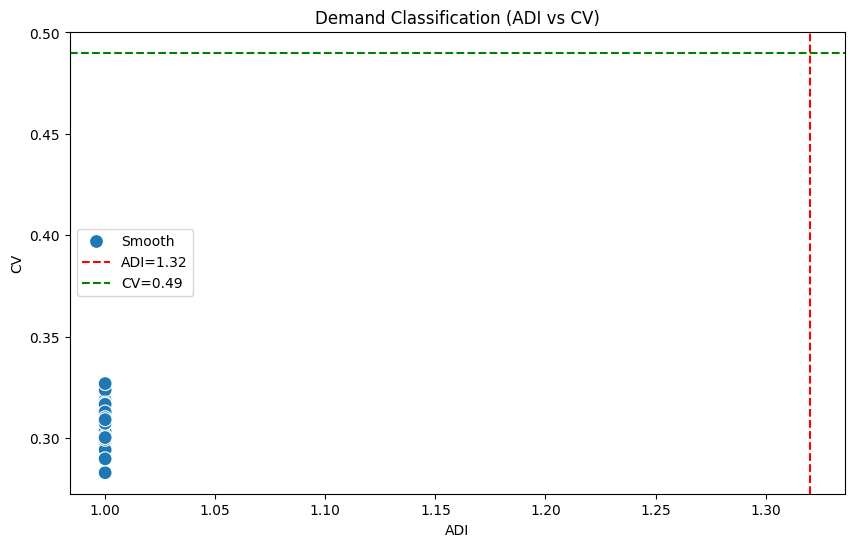

In [4]:
print("Demand Classification Summary:")
print(classification_df['Category'].value_counts())

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=classification_df, x='ADI', y='CV', hue='Category', style='Category', s=100)
plt.axvline(x=1.32, color='r', linestyle='--', label='ADI=1.32')
plt.axhline(y=0.49, color='g', linestyle='--', label='CV=0.49')
plt.title('Demand Classification (ADI vs CV)')
plt.legend()
plt.show()